# Regridding CMIP6
##### Here we regrid a user defined cmip6 grid to another user defined target grid. For this we use `xESMF`, `intake-esm`, `dask`, and `xarray`.
##### Initial benchmarking: 41 seconds/decade  downscale CESM2 to a ~12 km grid over CONUS

In [1]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Import packages
import xarray as xr
import xesmf as xe
import intake
import util 
import pprint 
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pandas as pd
from dask.distributed import Client
from dask_jobqueue import SLURMCluster 

In [2]:
# cluster = SLURMCluster(cores=2, memory='12GB', project='UCGD0006')
# cluster.adapt(minimum_cores=0, maximum_cores=30)
# client = Client(cluster)
# cluster = SLURMCluster(cores=36, memory='100GB', project='UCGD0006',
#                        processes=36)
# cluster.adapt(minimum=1*36, maximum=10*36)
from dask.diagnostics import ProgressBar

## Define temporal period of interest

In [3]:
t0 = '2000-01-01'
tf = '2009-12-31'

## Define target grid
##### This is the grid that we will interpolate CMIP6 data to. 

In [4]:
cat = intake.Catalog('/glade/u/home/jhamman/hap_data.yaml')
obs_ds = cat['gmet_v2'].to_dask()
tgt_grid = xr.Dataset({'lat': (['lat'], obs_ds['lat']),
                     'lon': (['lon'], obs_ds['lon'])})

## Retrieve CMIP6 data
##### This data will be regridded to the target grid.

In [5]:
# Querry CMIP6 data catalog for desired data
cat = intake.open_esm_datastore("../catalogs/glade-cmip6.json")
cat = cat.search(experiment_id = ['historical'], source_id = ['CESM2'], \
                 table_id = ['day'], variable_id = ['pr'], member_id = ['r2i1p1f1'])
cat.df.head()

# Create dataset
ds = cat.to_dataset_dict(cdf_kwargs={'chunks': {'time': 10}})
ds = ds['CMIP.NCAR.CESM2.historical.day.gn']['pr']
ds = ds.sel(time=slice(t0, tf))
ds = ds[0,:,:,:]
ds.data

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 1 group(s)


,Array,Chunk
Bytes,807.32 MB,2.21 MB
Shape,"(3650, 192, 288)","(10, 192, 288)"
Count,24839 Tasks,365 Chunks
Type,float32,numpy.ndarray


## Regrid CMIP6 grid to target grid

In [6]:
%time regridder = xe.Regridder(ds, tgt_grid, 'bilinear')
regridder.clean_weight_file()
regridded_ds = regridder(ds)
regridded_ds.data
with ProgressBar():
    regridded_ds = regridded_ds.persist() # Applies regridding (no longer lazy!)

Create weight file: bilinear_192x288_224x464.nc
CPU times: user 2.75 s, sys: 210 ms, total: 2.96 s
Wall time: 3.06 s
Remove file bilinear_192x288_224x464.nc
[########################################] | 100% Completed | 11.4s


## Unit Conversions

In [7]:
# # Currently the regirdded data is daily time resolution with units of kg/m^2/sec
# # Multiply by 86400 to transform to mm/day (the same as kg/m^2/day)
ds = ds * 86400
regridded_ds = regridded_ds * 86400

## Plot Regrided Data

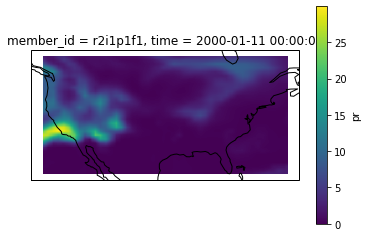

In [8]:
ax = plt.axes(projection=ccrs.PlateCarree())
regridded_ds.isel(time=10).plot.pcolormesh(ax=ax);
ax.coastlines();

## Compare observational data and CESM

In [9]:
# Define location
lat = 40
lon = -105.27

# Retrieve data
obs_ds = obs_ds.sel(time=slice(t0, tf))
obs_ds = obs_ds.sel(lon=lon, lat=lat, method='nearest')
regridded_ds = regridded_ds.sel(lon=lon, lat=lat, method='nearest')

# Calculate Monthly Averages (ma)
obs_ma = obs_ds.groupby('time.month').mean('time')
mod_ma = regridded_ds.groupby('time.month').mean('time')

## Plot Montly Average Comparison

Text(0, 0.5, 'Model')

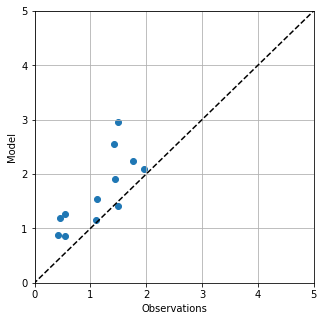

In [14]:
plt.figure(1, figsize = (5,5))
plt.scatter(obs_ma['pcp'], mod_ma)
plt.plot([-10, 10], [-10, 10], 'k--')
plt.xlim([0, 5])
plt.ylim([0, 5])
plt.grid()
plt.xlabel("Observations")
plt.ylabel("Model")